In [1]:
sc.setLogLevel("ERROR")

In [2]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

In [3]:
# read parquet files
hi_train_50 = spark.read.parquet("gs://st446-final-zqh/train_50.parquet")
hi_test_50 = spark.read.parquet("gs://st446-final-zqh/test_50.parquet")

In [4]:
hi_train_50.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+
|0x7954781a46be815...|11182956160400359...|   5.0|       4.6|           505| 207236|       2154|            1|            89483|
|0x79552bb823f236e...|10268804380821626...|   5.0|       4.9|           138|  46694|       3744|            1|           153100|
|0x7c006d382cfd097...|10124734323452185...|   5.0|       4.8|            18|  21570|       6820|            1|           301849|
|0x7c001271836a596...|11367503708955690...|   5.0|       4.7|          4873| 239646|       4075|            1|           169526|
|0x7c0014fcc76127d...|11178430594800496...|   5.0|       4.7|          7788| 206440|       4420| 

In [5]:
hi_train_50.count()

562086

In [6]:
hi_test_50.count()

62454

In [7]:
def grid_search(train_data, test_data):
    best_rmse = float("inf")
    best_model = None
    best_predictions = None
    best_rank = 0
    best_regParam = 0
    best_maxIter = 0
    for rank in [40, 50, 60, 70]:
        for regParam in [0.01, 0.1, 1]:
            for maxIter in [15, 20]:
                als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol="user_id", itemCol="business_id", ratingCol="rating_binary", coldStartStrategy="drop")
                model = als.fit(train_data)
                predictions = model.transform(test_data)
                evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating_binary", predictionCol="prediction")
                rmse = evaluator.evaluate(predictions)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_predictions = predictions
                    best_rank = rank
                    best_regParam = regParam
                    best_maxIter = maxIter
                print(f"rank = {rank}, regParam = {regParam}, maxIter = {maxIter}, RMSE = {rmse}")
    return best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter


In [ ]:
best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter = grid_search(hi_train_50, hi_test_50)
print("The best rank is: ", best_rank)
print("The best regParam is: ", best_regParam)
print("The best maxIter is: ", best_maxIter)
print("The best rmse is: ", best_rmse)

rank = 40, regParam = 0.01, maxIter = 15, RMSE = 0.5769276868457709
rank = 40, regParam = 0.01, maxIter = 20, RMSE = 0.5535786633735547
rank = 40, regParam = 0.1, maxIter = 15, RMSE = 0.5006054802045496
rank = 40, regParam = 0.1, maxIter = 20, RMSE = 0.4981200173416142
rank = 40, regParam = 1, maxIter = 15, RMSE = 0.792171624315899
rank = 40, regParam = 1, maxIter = 20, RMSE = 0.7921729628071644
rank = 50, regParam = 0.01, maxIter = 15, RMSE = 0.5659555411188748
rank = 50, regParam = 0.01, maxIter = 20, RMSE = 0.5445138248805726
rank = 50, regParam = 0.1, maxIter = 15, RMSE = 0.49971283143477874
rank = 50, regParam = 0.1, maxIter = 20, RMSE = 0.49730103497022843
rank = 50, regParam = 1, maxIter = 15, RMSE = 0.7921716381928069
rank = 50, regParam = 1, maxIter = 20, RMSE = 0.7921729592326099
rank = 60, regParam = 0.01, maxIter = 15, RMSE = 0.558314751741382
rank = 60, regParam = 0.1, maxIter = 15, RMSE = 0.4992823415487106
rank = 60, regParam = 0.1, maxIter = 20, RMSE = 0.497009768000324

In [9]:
best_predictions.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|prediction|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+
|0x795230fb4d772e7...|11833215860377174...|   3.0|       4.6|            78| 320928|        148|            0|             6296|0.29665795|
|0x795230fb4d772e7...|10310002472577615...|   5.0|       4.6|            78|  54085|        148|            1|             6270| 0.7830583|
|0x79524b4350eaed3...|10804277541688120...|   4.0|       4.2|            37| 140611|        463|            0|            17392|0.20867139|
|0x79524b4bbfe4a70...|10264308006145348...|   5.0|       4.0|            54|  45934|        496|            1|            17951|  0.641822|
|0x79524b4bbfe4a70..

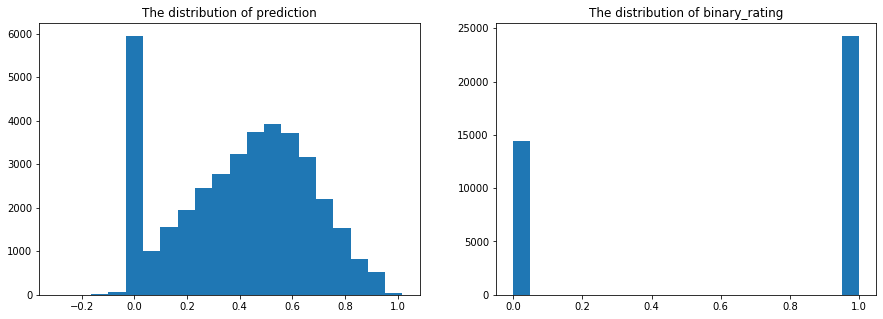

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

best_predictions_pd = best_predictions.toPandas()

# draw the ditrbution of prediction column
axs[0].hist(best_predictions_pd["prediction"], bins=20)
axs[0].set_title("The distribution of prediction")

# draw the ditrbution of rating column
axs[1].hist(best_predictions_pd["rating_binary"], bins=20)
axs[1].set_title("The distribution of binary_rating")

plt.show()

In [11]:
from pyspark.sql.functions import when, col

# define a function to evaluate the model
def evaluate_model(predictions):
    # calculate TP, FP, TN, FN
    TP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 1)).count()
    FP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 0)).count()
    TN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 0)).count()
    FN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 1)).count()

    # calculate Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    # calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) else 0

    return accuracy, precision, recall, f1_score, specificity

In [12]:
best_predictions = best_predictions.withColumn('prediction_binary', when(col('prediction') > 0, 1).otherwise(0))
accuracy, precision, recall, f1_score, specificity = evaluate_model(best_predictions)
print("The accuracy of the ALS model is:", accuracy)
print("The precision of the ALS model is:", precision)
print("The recall of the ALS model is:", recall)
print("The f1_score of the ALS model is:", f1_score)
print("The specificity of the ALS model is:", specificity)

The accuracy of the ALS model is: 0.6600062037946544
The precision of the ALS model is: 0.6688012139605463
The recall of the ALS model is: 0.9077315978086254
The f1_score of the ALS model is: 0.7701609380187674
The specificity of the ALS model is: 0.24262613644250122


In [13]:
# normalize the 'prediction' into 0-1

max_prediction = best_predictions.agg({"prediction": "max"}).collect()[0][0]
min_prediction = best_predictions.agg({"prediction": "min"}).collect()[0][0]

best_predictions = best_predictions.withColumn("probability", (best_predictions["prediction"] - min_prediction) / (max_prediction - min_prediction))

best_predictions.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+-----------------+-------------------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|prediction|prediction_binary|        probability|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+-----------------+-------------------+
|0x795230fb4d772e7...|10310002472577615...|   5.0|       4.6|            78|  54085|        148|            1|             6270| 0.7830583|                1| 0.8209031019815216|
|0x795230fb4d772e7...|11833215860377174...|   3.0|       4.6|            78| 320928|        148|            0|             6296|0.29665795|                1| 0.4504274573089181|
|0x79524b4350eaed3...|10804277541688120...|   4.0|       4.2|            37| 140611|        463|            0|

In [14]:
# draw the precision-recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

best_predictions_pd = best_predictions.toPandas()

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the roc curve
fpr, tpr, _ = roc_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the auc
auc_score = auc(fpr, tpr)
print(auc_score)

0.748531832353764


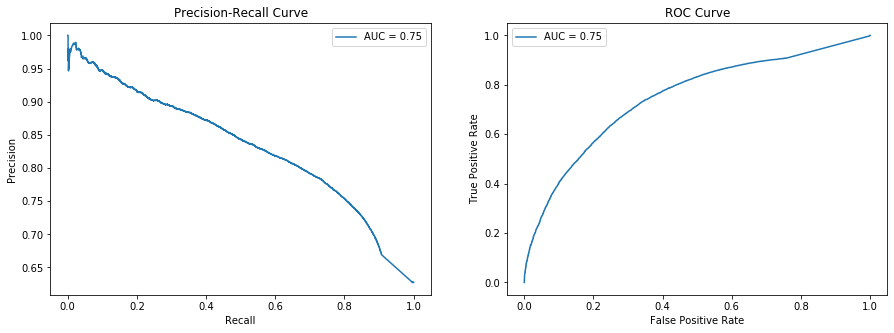

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the precision-recall curve
axs[0].plot(recall, precision, label="AUC = {:.2f}".format(auc_score))
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve")
axs[0].legend()

# draw the roc curve
axs[1].plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()

plt.show()